In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра
    9. Version 8 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014

### Этап 1: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [7]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint, strict=False).to("cuda:0")

anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['ner_model.model.embeddings.word_embeddings.weight', 'ner_model.model.embeddings.position_embeddings.weight', 'ner_model.model.embeddings.token_type_embeddings.weight', 'ner_model.model.embeddings.LayerNorm.weight', 'ner_model.model.embeddings.LayerNorm.bias', 'ner_model.model.encoder.layer.0.attention.self.query.weight', 'ner_model.model.encoder.layer.0.attention.self.query.bias', 'ner_model.model.encoder.layer.0.attention.self.key.weight', 'ner_model.model.encoder.layer.0.attention.self.key.bias', 'ner_model.model.encoder.layer.0.attention.self.value.weight', 'ner_model.model.encoder.layer.0.attention.self.value.bias', 'ner_model.model.encoder.layer.0.attention.output.dense.weight', 'ner_model.model.encoder.layer.0.attention.output.dense.bias', 'ner_model.model.encoder.layer.0.attention.output.LayerNorm.weight', 'ne

In [8]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization, device='cpu',
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Start data tokenization


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [02:26<00:00,  1.25it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

In [10]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9618864059448242
     test_precision         0.9618864059448242
       test_recall          0.7377423048019409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.7377423048019409,
  'test_precision': 0.9618864059448242,
  'test_f1': 0.9618864059448242}]

In [ ]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

  0%|          | 0/855 [00:00<?, ?it/s]

In [ ]:
# import importlib
# ner_metrics = importlib.import_module('utils.ner_metrics')
# ner_metrics = importlib.reload(ner_metrics)

In [ ]:
stats.get_specific_failed_predictions('LOCATION')

In [ ]:
stats.get_specific_failed_predictions('CONTACT')

**Вывод:**  
В целом все метки предсказываются с точностью, близкой к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 2: Обучение NER на анонимизированных с помощью ILM данных из того же набора

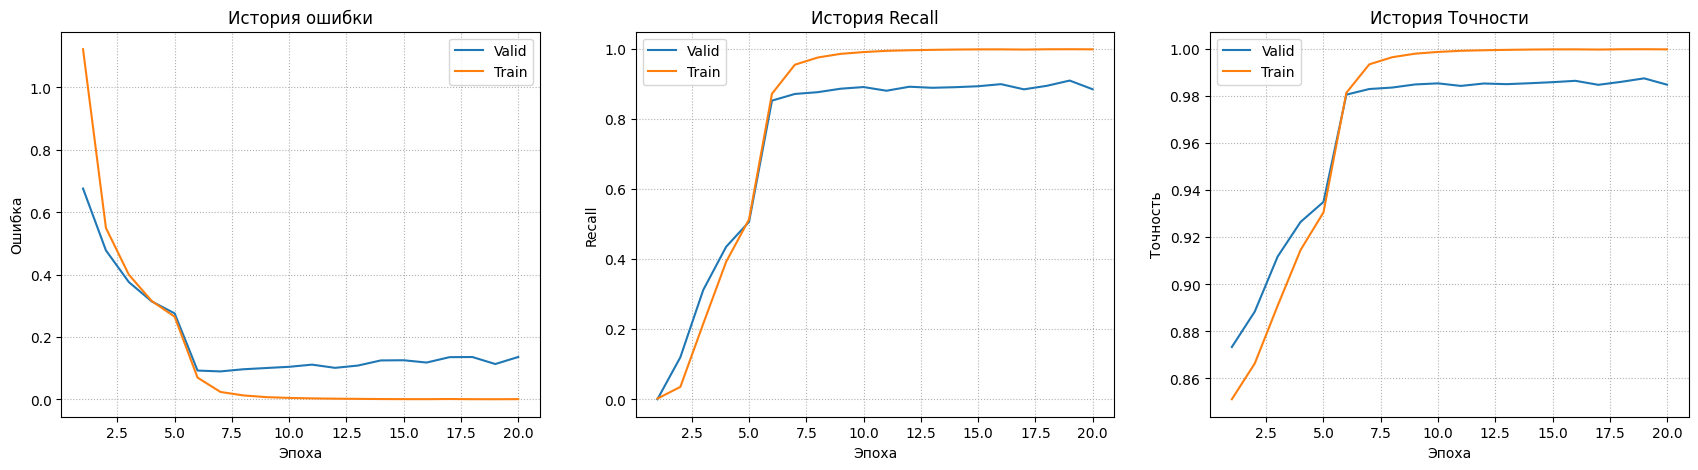

In [7]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(9)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(9)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9873901009559631
     test_precision         0.9873901009559631
       test_recall          0.9088882207870483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9088882207870483,
  'test_precision': 0.9873901009559631,
  'test_f1': 0.9873901009559631}]

              precision    recall  f1-score   support

        NAME     0.9888    0.9075    0.9464     90628
  PROFESSION     0.8291    0.5386    0.6530       856
    LOCATION     0.7647    0.6907    0.7258     17333
         AGE     0.9316    0.8935    0.9122      2028
        DATE     0.9847    0.9757    0.9802     99979
          ID     0.8931    0.8399    0.8657     20030
     CONTACT     0.9206    0.8539    0.8860     18993

   micro avg     0.9587    0.9089    0.9331    249847
   macro avg     0.9018    0.8143    0.8528    249847
weighted avg     0.9577    0.9089    0.9323    249847



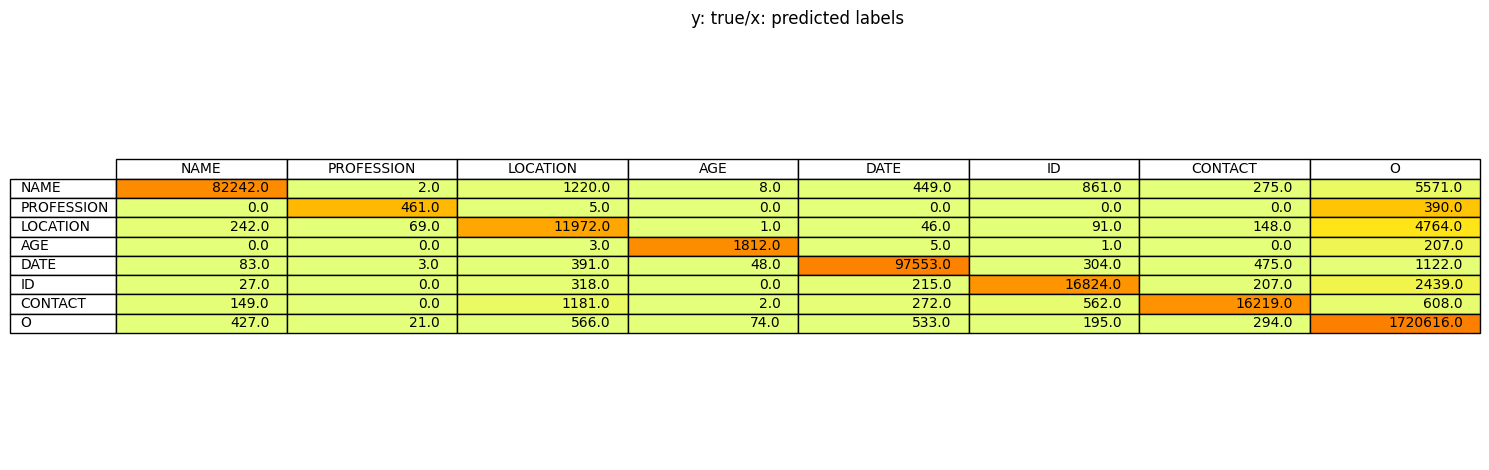

Wrongly predicted examples:
_____ Record 330-02:785 _____
| Sentence:    | ( | 30568   | ) but i am not always available. | olive tripp | , acnp, cde | dixmont state hospital | diabetes management service |
| True labels: | O | CONTACT | O                                | NAME        | O           | LOCATION               | O                           |
| Sentence:    | ( | 30568    | ) but i am not always available. | olive tripp | , acnp, cde | dixmont state hospital | diabetes management service |
| Pred labels: | O | LOCATION | O                                | NAME        | O           | LOCATION               | O                           |
_____ Record 189-04:474 _____
| Sentence:    | descending 70 % ; cx ostial disease ; right coronary artery moderate to severe ; plv. 80 to. 90 echo pending carotid non - invasive study pending social history other notes : dc smoke | 2062 | , married, retired for 20 years, no etoh. family history review of systems general : denies fevers, chil

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [12]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 176-04:299 _____
| Sentence:    | but does not use illicit drugs. he is a retired | transporation manager | , and he was previously living with his girlfriend, but has now been living alone for the last week. physical examination : when he presented, he had a heart rate of 65, respiratory rate of 16, bp of 150 / 79, and saturating 99 % on room air. he was afebrile at 96. 7. he was alert, interactive, appropriate, somewhat slurred speech, but gave a |
| True labels: | O                                               | PROFESSION            | O                                                                                                                                                                                                                                                                                                                                                        |
| Sentence:    | but does not use illicit drugs. he is a retired t

['100-01:180',
 '100-03:180',
 '100-03:240',
 '102-03:240',
 '102-03:300',
 '106-01:600',
 '106-02:241',
 '106-02:300',
 '106-03:477',
 '106-03:537',
 '108-02:536',
 '108-02:595',
 '108-04:1018',
 '108-04:959',
 '120-01:120',
 '120-02:121',
 '120-02:180',
 '125-01:0',
 '125-01:60',
 '125-02:659',
 '125-02:718',
 '125-03:717',
 '126-01:720',
 '126-01:778',
 '126-02:356',
 '126-05:655',
 '127-03:303',
 '127-05:656',
 '141-02:598',
 '141-02:657',
 '144-04:60',
 '146-04:654',
 '146-04:713',
 '147-03:419',
 '149-03:240',
 '149-03:300',
 '151-02:597',
 '151-02:656',
 '158-04:1193',
 '158-04:1252',
 '170-03:1078',
 '170-04:482',
 '170-05:241',
 '174-01:181',
 '174-01:240',
 '174-05:360',
 '174-05:418',
 '175-03:480',
 '176-04:239',
 '176-04:299',
 '179-04:1318',
 '185-03:479',
 '185-03:539',
 '187-01:656',
 '187-03:1309',
 '187-03:1369',
 '187-04:1547',
 '188-02:119',
 '189-05:960',
 '220-04:776',
 '220-04:836',
 '220-05:717',
 '220-05:777',
 '223-02:117',
 '223-02:177',
 '223-03:237',
 '223-

In [13]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 398-04:840 _____
| Sentence:    | hrc      | urology | 59931   |
| True labels: | LOCATION | O       | CONTACT |
| Sentence:    | hrc      | urology | 59931    |
| Pred labels: | LOCATION | O       | LOCATION |
_____ Record 303-04:1582 _____
| Sentence:    | page | 21358   | with all questions, comments or concerns while still in the ed discussed with senior resident dr. | z. newell |
| True labels: | O    | CONTACT | O                                                                                                 | NAME      |
| Sentence:    | page | 21358   | with all questions, comments or concerns while still in the ed discussed with senior resident dr. | z. newell |
| Pred labels: | O    | CONTACT | O                                                                                                 | NAME      |


['100-04:1083',
 '100-05:2635',
 '100-05:2704',
 '100-05:2719',
 '104-03:2095',
 '104-03:2123',
 '104-03:2126',
 '104-03:2128',
 '104-03:2130',
 '104-03:2131',
 '104-03:2132',
 '104-03:2133',
 '104-03:2134',
 '104-03:2135',
 '104-03:2139',
 '104-03:2155',
 '104-03:2159',
 '104-03:2160',
 '105-05:1614',
 '107-04:357',
 '107-04:376',
 '107-04:377',
 '107-04:378',
 '107-04:379',
 '107-04:380',
 '107-04:381',
 '107-04:382',
 '107-04:383',
 '107-04:384',
 '107-04:385',
 '107-04:386',
 '107-04:387',
 '107-04:388',
 '107-04:389',
 '107-04:390',
 '107-04:391',
 '107-04:392',
 '107-04:393',
 '107-04:396',
 '107-04:398',
 '107-04:399',
 '107-04:401',
 '107-04:402',
 '107-04:405',
 '107-04:409',
 '107-04:410',
 '107-04:413',
 '107-04:414',
 '109-04:636',
 '109-04:637',
 '109-04:638',
 '121-04:0',
 '126-01:2306',
 '126-01:2307',
 '126-03:1562',
 '127-03:2528',
 '127-03:2530',
 '127-04:1571',
 '127-05:1370',
 '127-05:1430',
 '128-04:1425',
 '129-04:2087',
 '129-04:2113',
 '129-04:2114',
 '129-04:21

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

### Этап 3: Обучение NER на анонимизированных с помошью ILM данных из другого набора в том же домене

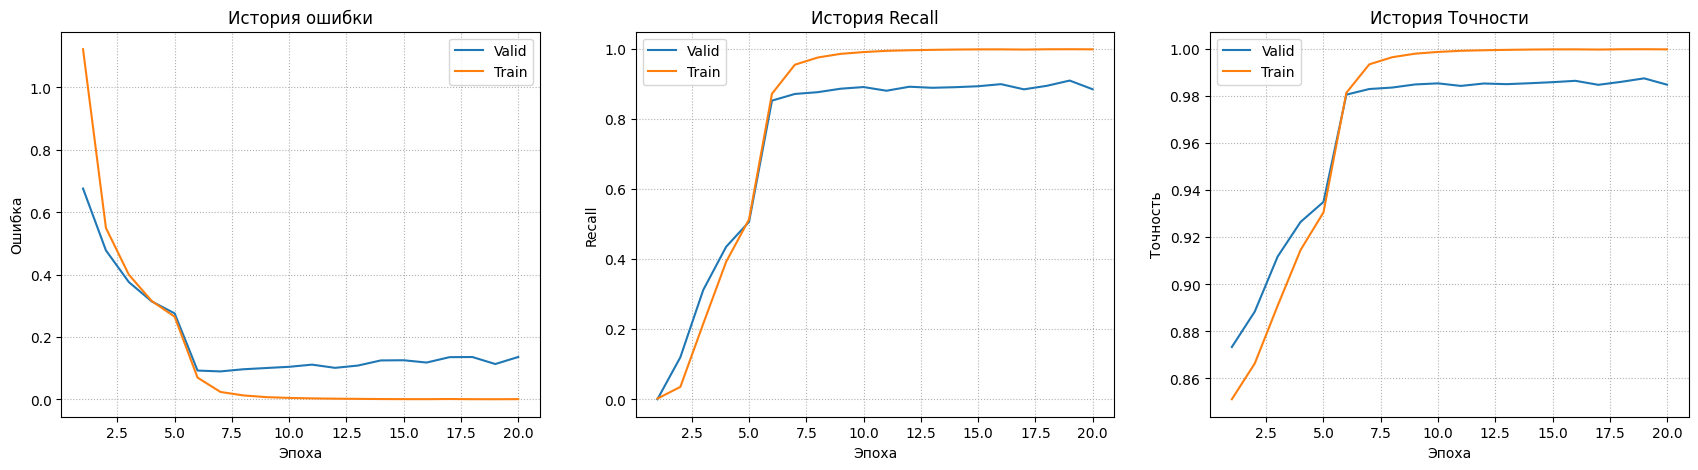

In [14]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(9)

In [15]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [16]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(9)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [17]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9262829422950745
     test_precision         0.9262829422950745
       test_recall          0.7140571475028992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.7140571475028992,
  'test_precision': 0.9262829422950745,
  'test_f1': 0.9262829422950745}]

              precision    recall  f1-score   support

        NAME     0.9314    0.6678    0.7778     31938
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.5486    0.4077    0.4677      8085
         AGE     0.0120    0.5000    0.0234        10
        DATE     0.5802    0.9719    0.7266     21502
          ID     0.9126    0.5597    0.6938     11178
     CONTACT     0.5448    0.7617    0.6353      2921

   micro avg     0.7077    0.7141    0.7108     75634
   macro avg     0.5042    0.5527    0.4750     75634
weighted avg     0.7728    0.7141    0.7121     75634



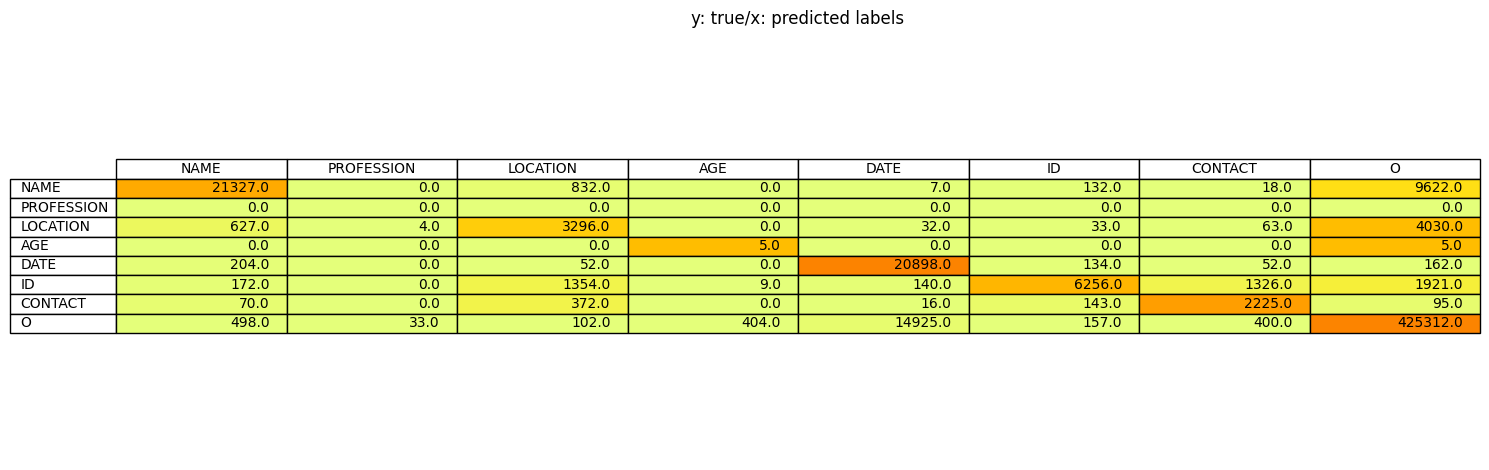

Wrongly predicted examples:
_____ Record 538:1504 _____
| Sentence:    | . | sandshaearl areas | , m. d. tr : | fa / bmot | dd : | 12 / 6 | / 93 td : | 12 / 07 | / 93 cc : [ report _ end ] |
| True labels: | O | NAME              | O            | NAME      | O    | DATE   | O         | DATE    | O                          |
| Sentence:    | . sandshaearl areas | , m. d. tr : fa / bmot dd : | 12 / 6 / 93 | td : | 12 / 07 / 93 | cc : [ report _ end ] |
| Pred labels: | NAME                | O                           | DATE        | O    | DATE         | O                     |
_____ Record 420:120 _____
| Sentence:    | used as the d / c summary : yes attending : | fyfezeisleitz, mata l. | , m. d. disposition : home discharge medications : captopril 50 mg po bid food / drug interaction instruction give on an empty stomach ( give 1hr before or 2hr after food ) override notice : override added on | 06 / 09 | / 04 by | aylesmespkays, shamenualna iruss | , m. d. on order for k - dur |
| Tr

In [18]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [19]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 625:0 _____
| Sentence:    | 319814231 | fih      | 9717992 185119 498061 | 02 / 05 | / 1998 12 : 00 : 00 am left patellar fracture. unsigned dis report status : unsigned discharge summary name : | oberal, rayno | unit number : | 134 - 74 - 82 | admission date : | 02 / 05 | / 1998 discharge date : | 02 / 09 | / 1998 principal diagnosis : left patellar fracture. special procedures and operations : orif of left patellar fracture | february 6 | , 1998. history |
| True labels: | ID        | LOCATION | ID                    | DATE    | O                                                                                                             | NAME          | O             | ID            | O                | DATE    | O                       | DATE    | O                                                                                                                       | DATE       | O               |
| Sentence:    | 319814231 fih 9717992 1851

['111:0',
 '111:662',
 '111:720',
 '135:0',
 '151:0',
 '151:60',
 '168:0',
 '168:1257',
 '168:2208',
 '177:0',
 '177:119',
 '177:1373',
 '177:1433',
 '177:177',
 '185:0',
 '185:1253',
 '185:1306',
 '185:1307',
 '185:1309',
 '185:1313',
 '185:1314',
 '185:1317',
 '185:1318',
 '185:1319',
 '185:1320',
 '185:1321',
 '185:1322',
 '185:1323',
 '185:1325',
 '185:1326',
 '185:1327',
 '185:1329',
 '185:1332',
 '185:1333',
 '185:1334',
 '185:1336',
 '185:1337',
 '185:180',
 '185:240',
 '194:0',
 '194:120',
 '194:180',
 '194:595',
 '194:655',
 '202:0',
 '202:1373',
 '202:1433',
 '202:1552',
 '202:237',
 '202:297',
 '206:0',
 '214:0',
 '214:240',
 '214:480',
 '220:0',
 '220:60',
 '233:0',
 '233:1137',
 '233:1197',
 '233:538',
 '233:598',
 '420:0',
 '420:302',
 '420:360',
 '420:60',
 '420:839',
 '422:0',
 '422:1310',
 '422:1370',
 '422:1610',
 '422:1670',
 '422:1694',
 '422:1696',
 '422:1697',
 '422:1706',
 '422:1708',
 '422:1709',
 '422:1710',
 '422:1712',
 '422:1714',
 '422:1715',
 '422:1716',
 

In [20]:
stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 487:200 _____
| Sentence:    | name : | guallsman, maeuse j | provider number : | 86439 | [ report _ end ] |
| True labels: | O      | NAME                | O                 | ID    | O                |
| Sentence:    | name : | guallsman | , | maeuse   | j provider number : | 86439   | [ report _ end ] |
| Pred labels: | O      | NAME      | O | LOCATION | O                   | CONTACT | O                |
_____ Record 475:220 _____
| Sentence:    | : | 52462 | [ report _ end ] |
| True labels: | O | ID    | O                |
| Sentence:    | : | 52462 | [ report _ end ] |
| Pred labels: | O | DATE  | O                |


['111:0',
 '111:1197',
 '111:1257',
 '135:0',
 '135:1610',
 '135:1670',
 '135:1720',
 '135:1721',
 '135:1723',
 '135:1724',
 '151:0',
 '151:60',
 '151:777',
 '151:837',
 '151:866',
 '151:867',
 '151:868',
 '151:869',
 '151:870',
 '151:871',
 '151:872',
 '151:873',
 '151:874',
 '168:0',
 '168:2388',
 '168:2421',
 '168:2422',
 '168:2423',
 '168:2424',
 '168:2425',
 '168:2426',
 '168:2427',
 '168:2437',
 '168:2438',
 '168:2439',
 '177:0',
 '177:1612',
 '177:1636',
 '177:1637',
 '177:1638',
 '177:1639',
 '177:1640',
 '177:1641',
 '177:1642',
 '177:1643',
 '177:1644',
 '177:1645',
 '177:1646',
 '177:1647',
 '177:1648',
 '177:1649',
 '177:1650',
 '177:1651',
 '177:1652',
 '185:0',
 '185:1194',
 '185:1253',
 '194:0',
 '194:1969',
 '194:2028',
 '194:2029',
 '194:2030',
 '194:2031',
 '194:2032',
 '194:2033',
 '194:2034',
 '194:2036',
 '194:2037',
 '194:2038',
 '194:2039',
 '194:2040',
 '194:2041',
 '194:2042',
 '194:2043',
 '194:2044',
 '194:2045',
 '194:60',
 '202:0',
 '206:715',
 '206:775',
 

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных: